In [36]:
from dataclasses import dataclass

@dataclass
class SimulationParameters:
    service_lambda: float
    on_off_lambda: float
    capacity: int
    loss_probability: float
    message_lambda: float
    message_lifetime: int
    
@dataclass
class SimulationResults:
    n_messages_generated: int
    n_messages_lost: int
    n_messages_expired: int
    n_messages_completed: int
    averate_response_time: float

In [37]:
from main import MessageGenerator, OnOffServer, Sink, MessageState, Simulation, Message
from typing import Dict, List

varried_arrival_rates_key = "varried_arrival_rates"
simulation_parameter_lists: Dict[str, List[SimulationParameters]] = dict()

# 90 minutes in ms
simulation_length = 60 * 1000 * 90

simulation_parameter_lists[varried_arrival_rates_key] = []

for message_lambda in range(0, 100):
    simulation_parameter_lists[varried_arrival_rates_key].append(
        SimulationParameters(1, 1, 1, 1, message_lambda * 0.1, simulation_length)
    )
    
simulation_result_lists: Dict[str, List[SimulationResults]] = dict()

for key, parameters in simulation_parameter_lists.items():
    simulation_result_lists[key] = []

    for simulation_parameters in parameters:
        message_generator = MessageGenerator(l=simulation_parameters.message_lambda, lifetime=simulation_parameters.message_lifetime)
        server = OnOffServer(
            service_lambda=simulation_parameters.service_lambda, state_flop_lambda=simulation_parameters.on_off_lambda, capacity=simulation_parameters.capacity, loss_probability=simulation_parameters.loss_probability
        )
        sink = Sink("Completed Messages", MessageState.COMPLETED)
        lostSink = Sink("Lost / Expired Messages")

        message_generator.register_output_listener(server)
        server.register_output_listener(sink)
        server.register_loss_output_listener(lostSink)

        simulation = Simulation()
        simulation.register_component(message_generator)
        simulation.register_component(server)
        simulation.register_component(sink)
        simulation.register_component(lostSink)

        # Simulate for 10000ms -> 10s
        simulation.simulate(0, 10000)
        
        simulation_result_lists[key].append(
            SimulationResults(
                n_messages_generated=message_generator.n_messages_generated,
                n_messages_lost=len([message for message in lostSink.messages if message.state is MessageState.LOST]),
                n_messages_expired=len([message for message in lostSink.messages if message.state is MessageState.EXPIRED]),
                n_messages_completed=len([message for message in sink.messages if message.state is MessageState.COMPLETED]),
                averate_response_time=((sum([message.response_time() for message in sink.messages]) / message_generator.n_messages_generated) if message_generator.n_messages_generated > 0 else 0)
            )
        )

Arrival Rate Vs Response Time Graph:


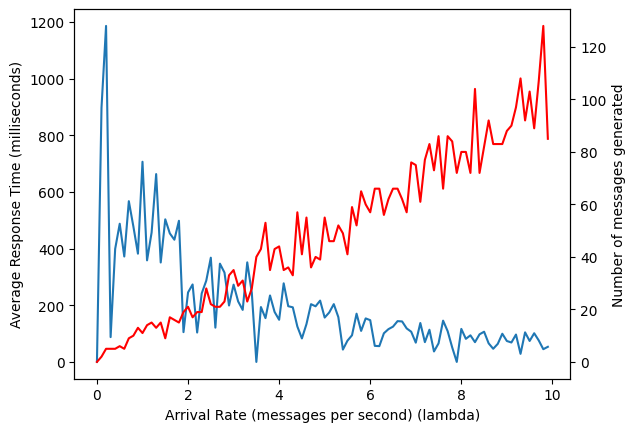

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

arrival_rate_message_lambdas: List[float] = [parameters.message_lambda for parameters in simulation_parameter_lists[varried_arrival_rates_key]]
arrival_rate_response_times: List[float] = [result.averate_response_time for result in simulation_result_lists[varried_arrival_rates_key]]
arrival_rate_n_messages_generated: List[int] = [result.n_messages_generated for result in simulation_result_lists[varried_arrival_rates_key]]

ax.plot(arrival_rate_message_lambdas, arrival_rate_response_times)

ax1 = ax.twinx()
ax1.plot(arrival_rate_message_lambdas, arrival_rate_n_messages_generated, color="red")

ax.set_xlabel(xlabel="Arrival Rate (messages per second) (lambda)")
ax.set_ylabel(ylabel="Average Response Time (milliseconds)")
ax1.set_ylabel(ylabel="Number of messages generated")


print("Arrival Rate Vs Response Time Graph:")
